This notebook is adpated based on https://www.kaggle.com/jingw222/stanford-dogbreeds-a-transfer-learning-tutorial#Confusion-matrix-analysis

In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import tensorflow as tf
import multiprocessing as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from run_funcs import *

assert sys.version_info >= (3, 5), 'Python ≥3.5 required'
assert tf.__version__ >= '2.0', 'TensorFlow ≥2.0 required' 

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

AUTOTUNE = tf.data.experimental.AUTOTUNE

TEST_SIZE = 0.2
INPUT_IMAGE_SIZE = 224

BATCH_SIZE = 24
EPOCH = 5

In [19]:
ANNOTATION_DIR = pathlib.Path('G:/Github/standford-dogs/annotations/Annotation/')
IMAGES_DIR = pathlib.Path('G:/Github/standford-dogs/images/Images')

BREED_DIR = [path for path in IMAGES_DIR.iterdir()]
BREED_DIR_NAME = [path.name for path in BREED_DIR]

BREED_CODE_TO_NAME = {breed.split('-')[0]: breed[10:] for breed in BREED_DIR_NAME}
BREED_NAME_TO_CODE = {v: k for k, v in BREED_CODE_TO_NAME.items()}

BREED_LABEL_TO_CODE = {i: code for i, code in enumerate(BREED_CODE_TO_NAME)}
BREED_CODE_TO_LABEL = {v: k for k, v in BREED_LABEL_TO_CODE.items()}

BREED_LABEL_TO_NAME = {i: BREED_CODE_TO_NAME[code] for i, code in BREED_LABEL_TO_CODE.items()}
BREED_NAME_TO_LABEL = {v: k for k, v in BREED_LABEL_TO_NAME.items()}

Set directory path, variable names etc

In [39]:
def path_to_label(path):
    code = path.stem.split('_')[0]
    return BREED_CODE_TO_LABEL[code]


def get_all_file_path(directory, file_pattern=''):
    paths = list(f for f in directory.rglob('**/*{}'.format(file_pattern)) if f.is_file())
    return sorted(paths, key=str) 
    
    
all_image_paths = get_all_file_path(IMAGES_DIR, '.jpg') # PosixPath
all_image_labels = [path_to_label(path) for path in all_image_paths] # [0,1,2,...]

assert len(all_image_paths)==len(all_image_labels), 'Numbers of images and labels not match! {}!={}'.format(len(all_image_paths), len(all_image_labels))

# Write labels to file 
with open('labels.txt', 'w') as f:
    f.write('\n'.join(BREED_NAME_TO_LABEL))

In [95]:
str(all_image_cropped_paths[0]).replace("\\","/").split('/')[-1]

'n02085620_10074.jpg'

In [104]:
# Crop images according to bounding boxes
try:
    pool = mp.Pool(processes=mp.cpu_count())
    pool.map(crop_and_save_image, all_image_paths)
except Exception as e:
    print(e)
finally:
    pool.close()

all_image_cropped_paths = get_all_file_path(IMAGES_CROPPED_DIR, '.jpg') # PosixPath
all_image_cropped_labels = [path_to_label(path) for path in all_image_cropped_paths] # [0,1,2,...]

#assert len(all_image_paths)==len(all_image_cropped_paths), 'Numbers of images and cropped images not match! {}!={}'.format(len(all_image_paths), len(all_image_cropped_paths))

In [118]:
CROPPED_DIR = pathlib.Path('G:/Github/standford-dogs/cropped')
all_images_cropped = get_all_file_path(CROPPED_DIR, '.jpg')

In [120]:
train_set,val_set = train_test_split(all_images_cropped,test_size = 0.2,shuffle = True, random_state=22)

In [136]:
len(val_set)

4116

In [122]:
# Organized cropped images into sub folders where the name is breed name, prep for TF training
for label in set(all_image_cropped_labels):
    os.mkdir(f'G:\\Github\\standford-dogs\\cropped\\train\\{BREED_LABEL_TO_NAME[label]}\\')
    os.mkdir(f'G:\\Github\\standford-dogs\\cropped\\validation\\{BREED_LABEL_TO_NAME[label]}\\')

In [127]:
train_set_label = [str(path).split('\\')[-2] for path in train_set]

In [129]:
val_set_label = [str(path).split('\\')[-2] for path in val_set]

In [131]:
for path,label in zip(train_set,train_set_label):
    os.rename(str(path), f'G:\\Github\\standford-dogs\\cropped\\train\\{label}\\'+str(path).split("\\")[-1])
    
for path,label in zip(val_set,val_set_label):
    os.rename(str(path), f'G:\\Github\\standford-dogs\\cropped\\validation\\{label}\\'+str(path).split("\\")[-1])

Let's try to see a random dog from the collection

In [14]:
IMAGE_PATH = get_all_file_path(IMAGES_DIR, '.jpg')

Random dog:  beagle


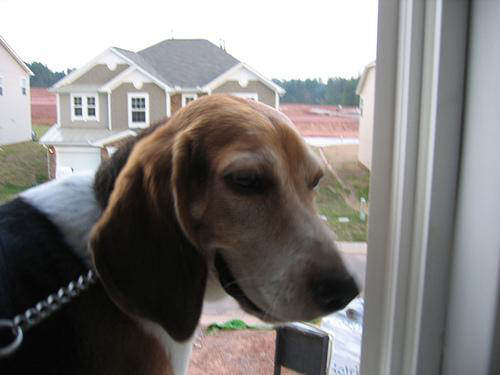

In [37]:
# Ramdomly check a dog image from the dataset
dog = np.random.choice(IMAGE_PATH)
print('Random dog: ', BREED_LABEL_TO_NAME[path_to_label(dog)])
Image.open(dog)

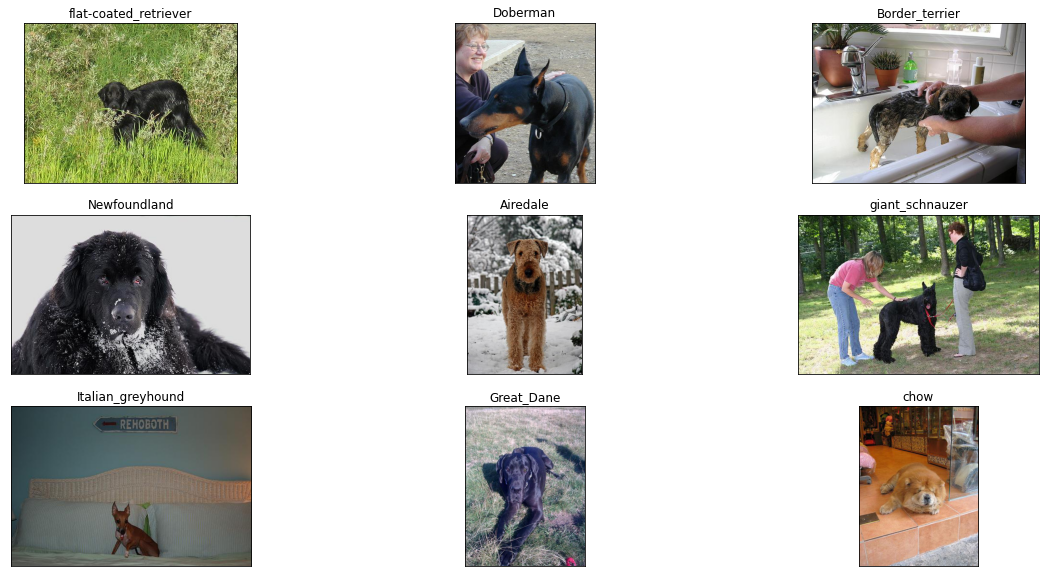

In [114]:
def show_random_dogs(path = IMAGE_PATH):
    '''
    Show nine random dog photos from the database
    '''
    plt.figure(figsize=(20, 10))
    for i in range(1,10):
        plt.subplot(3,3,i)
        
        dog = np.random.choice(IMAGE_PATH)
        im = np.array(Image.open(dog))
        plt.imshow(im)
        
        #Remove ticks for pictures
        plt.xticks([])
        plt.yticks([])
        
        #Add title as breed name
        plt.title(BREED_LABEL_TO_NAME[path_to_label(dog)])
    
show_random_dogs()

Now check some cropped images

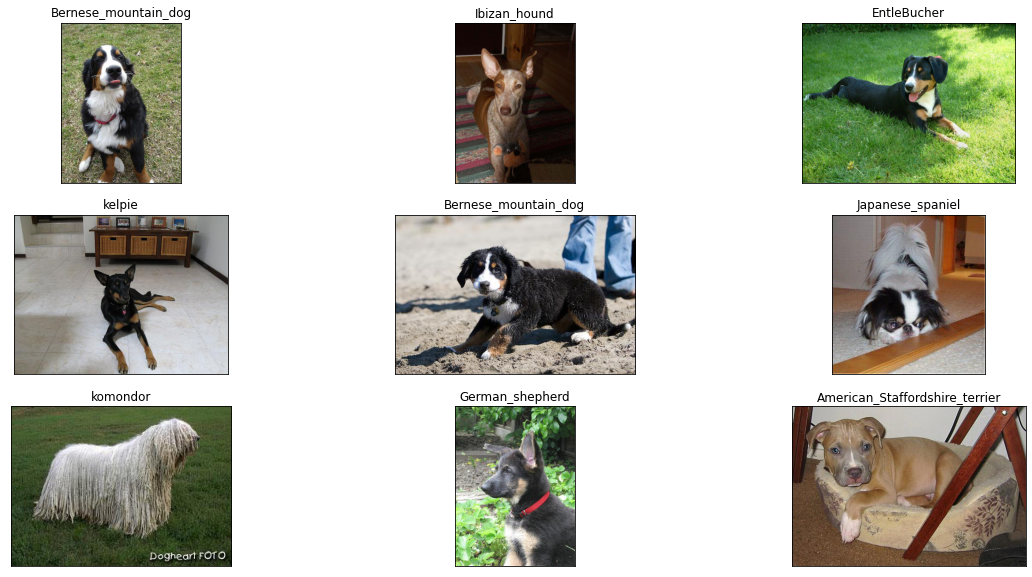

In [117]:
CROPPED_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
CROPPED_PATH = get_all_file_path(CROPPED_DIR, '.jpg')
show_random_dogs(CROPPED_PATH)

How many dog pics in each breed?

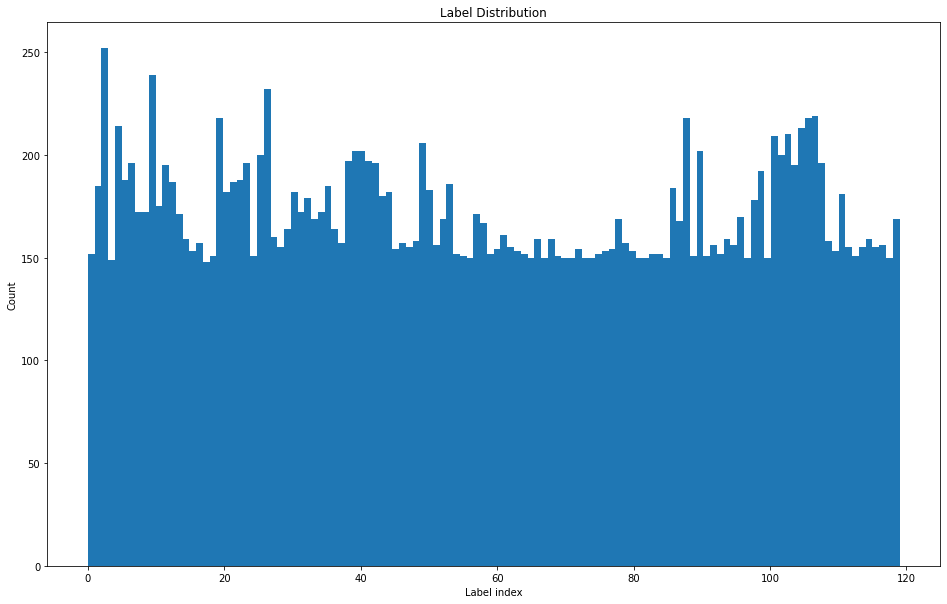

In [38]:
LABEL = all_image_labels
plt.figure(figsize=(16,10))
# Label distribution
_ = plt.hist(LABEL, bins=120)
plt.xlabel('Label index')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

We observed that for each breed there are at least ~ 140 images

We also want to check the train test split distribution that we just made

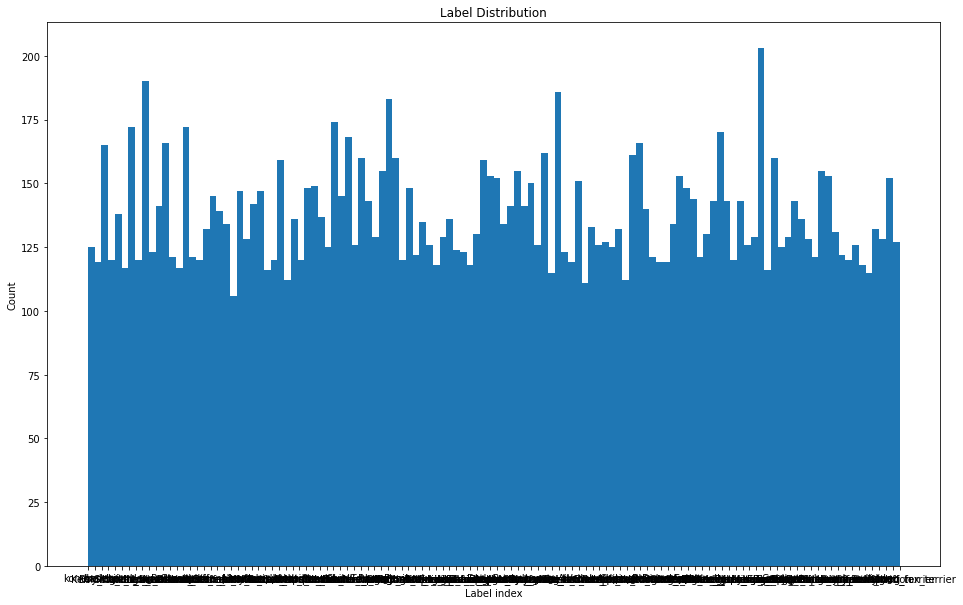

In [134]:
LABEL = train_set_label
plt.figure(figsize=(16,10))
# Label distribution
_ = plt.hist(LABEL, bins=120)
plt.xlabel('Label index')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

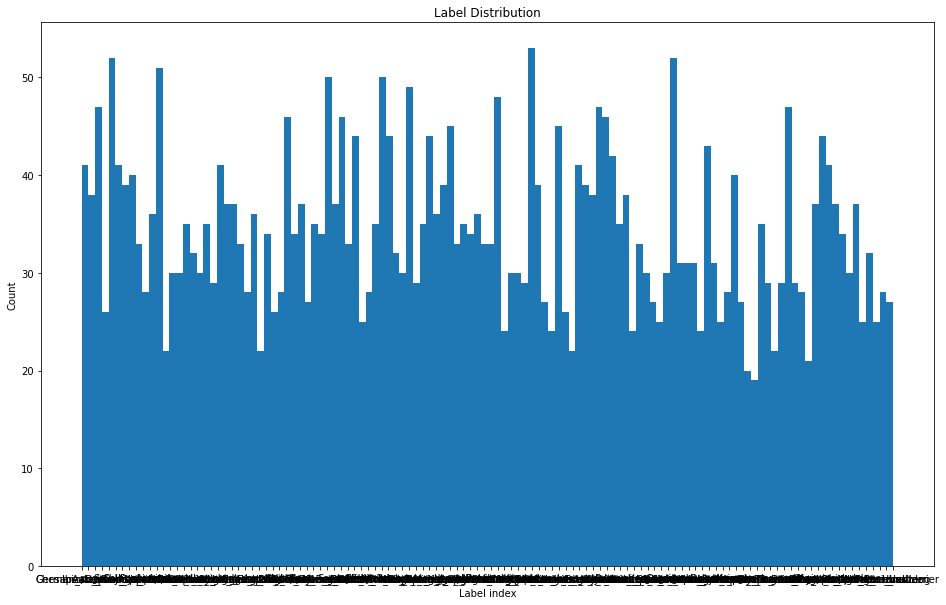

In [135]:
LABEL = val_set_label
plt.figure(figsize=(16,10))
# Label distribution
_ = plt.hist(LABEL, bins=120)
plt.xlabel('Label index')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()